In [19]:
#imports
import pandas as pd
from hw_demo_estimation import etl, graph_manipulation as gm, data_viz as dv


In [20]:
nodes, edges = etl.load_and_select_profiles_and_edges()
G = gm.create_graph_from_nodes_and_edges(nodes, edges)

loading profiles
loading edges
1    2642113
2    1992414
Name: source, dtype: int64
Selected profiles: 695406
Nodes with edges: 434590


In [21]:
nodes

,user_id,public,gender,region,AGE,TRAIN_TEST
0,1,1,1.0,"zilinsky kraj, zilina",26.0,TRAIN
4,4,1,0.0,"banskobystricky kraj, brezno",26.0,TRAIN
5,17,1,0.0,"zilinsky kraj, martin",27.0,TRAIN
6,5,1,1.0,"zilinsky kraj, zilina",26.0,TRAIN
7,18,1,1.0,"zilinsky kraj, kysucke nove mesto",18.0,TRAIN
...,...,...,...,...,...,...
1632778,1632779,1,1.0,"trenciansky kraj, myjava",34.0,TRAIN
1632781,1632782,1,1.0,"bratislavsky kraj, bratislava - nove mesto",32.0,TRAIN
1632782,1632783,1,1.0,"trenciansky kraj, povazska bystrica",37.0,TRAIN
1632784,1632785,1,1.0,"trenciansky kraj, povazska bystrica",37.0,TRAIN


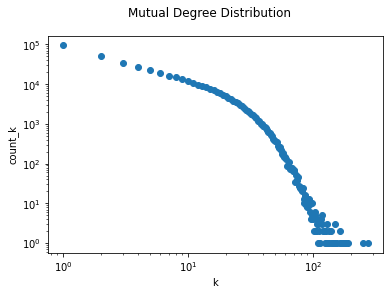

In [22]:
dv.plot_degree_distribution(G)

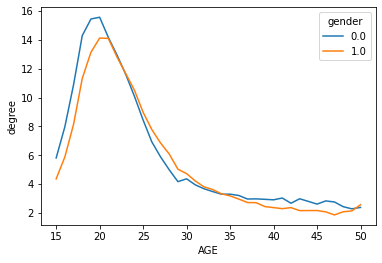

In [23]:
#creating a correlation analysis between network characteristics and user demographics
#Degree Centrality: the number of edges incident upon a node in the network
dv.plot_node_degree_by_gender(nodes, G)

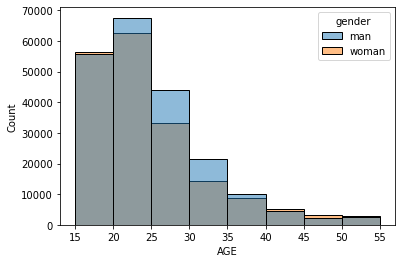

In [24]:
#this graph shows how each gender is distributed by age,
#and the ration between the two genders per age group
dv.plot_age_distribution_by_gender(nodes)

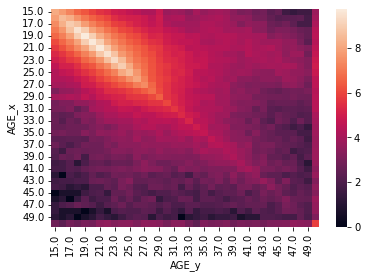

In [25]:
#creating heat map that indicates the number of connections between age groups of the 2 gender with different shades
edges_feat = gm.add_node_features_to_edges(nodes, edges)
dv.plot_age_relations_heatmap(edges_feat)

In [26]:
# to be able to efficiently analyse the database, we separated it based on the 'TRAIN_TEST' column of nodes
# the two sections are the 'TEST' and 'TRAIN' sections
is_train = nodes['TRAIN_TEST'] == 'TRAIN'
nodes_train = nodes[is_train]
is_test = nodes['TRAIN_TEST'] == 'TEST'
nodes_test = nodes[is_test]

In [27]:
#creating graphs for both 'TEST' and 'TRAIN' sections
G_test = gm.create_graph_from_nodes_and_edges(nodes_test, edges)
G_train = gm.create_graph_from_nodes_and_edges(nodes_train, edges)

In [28]:
# 
from tqdm import tqdm


pred_gend = []
for userid in tqdm(nodes_test.user_id):
    neighbors_it = set(G_train.neighbors(userid))
    genders = nodes_train[nodes_train.user_id.isin(neighbors_it)].dropna().groupby('gender').count()
    try:
        males = genders.loc[1, 'user_id']
    except:
        males = 0
    try:
        females = genders.loc[0, 'user_id']
    except:
        females = 0

    if males >= females:
        pred_gend.append(1)
    else:
        pred_gend.append(0)

prediction = pd.DataFrame(dict(user_id = nodes_test.user_id, gender = pred_gend))

100%|██████████| 40000/40000 [05:08<00:00, 129.72it/s]


In [29]:
prediction

,user_id,gender
21,11,1
44,27,1
54,29,1
62,92,1
66,93,1
...,...,...
1632018,1632019,1
1632203,1632204,0
1632378,1632379,0
1632510,1632511,1


In [30]:
# we created a train subsample to evaluate the accuracy of the used method.

nodes=nodes.dropna()
nodes_test_sub=nodes.sample(n=40000)
nodes_test_sub

,user_id,public,gender,region,AGE,TRAIN_TEST
61469,61452,1,0.0,"presovsky kraj, poprad",23.0,TRAIN
1338802,1338818,1,0.0,"trenciansky kraj, partizanske",21.0,TRAIN
1164286,1164203,1,0.0,"nitriansky kraj, sahy",21.0,TRAIN
369081,369152,1,1.0,"nitriansky kraj, komarno",20.0,TRAIN
645387,645415,1,0.0,"trenciansky kraj, partizanske",18.0,TRAIN
...,...,...,...,...,...,...
629402,629392,1,1.0,"trenciansky kraj, puchov",32.0,TRAIN
418552,418588,1,0.0,"nitriansky kraj, nove zamky",20.0,TRAIN
442187,442223,1,1.0,"nitriansky kraj, sala",19.0,TRAIN
411356,411414,1,1.0,"banskobystricky kraj, rimavska sobota",50.0,TRAIN


In [31]:
from tqdm import tqdm

pred_gend = []
for userid in tqdm(nodes_test_sub.user_id):
    neighbors_it = set(G_train.neighbors(userid))
    genders = nodes_train[nodes_train.user_id.isin(neighbors_it)].dropna().groupby('gender').count()
    try:
        males = genders.loc[1, 'user_id']
    except:
        males = 0
    try:
        females = genders.loc[0, 'user_id']
    except:
        females = 0

    if males >= females:
        pred_gend.append(1)
    else:
        pred_gend.append(0)

prediction_train = pd.DataFrame(dict(user_id = nodes_test_sub.user_id, gender = nodes_test_sub.gender, pred_gend = pred_gend))

100%|██████████| 40000/40000 [05:03<00:00, 131.80it/s]


In [32]:
prediction_train

,user_id,gender,pred_gend
61469,61452,0.0,1
1338802,1338818,0.0,1
1164286,1164203,0.0,1
369081,369152,1.0,1
645387,645415,0.0,1
...,...,...,...
629402,629392,1.0,1
418552,418588,0.0,1
442187,442223,1.0,1
411356,411414,1.0,1


In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix

obs = nodes_test_sub.gender.dropna()
prediction2 = prediction_train.pred_gend

accuracyscore = accuracy_score(obs, prediction2)
confusionmatrix = confusion_matrix(obs, prediction2)
print(f"The confusion matrix is:\n{confusionmatrix}\n with the accuracy score of: {accuracyscore}")

The confusion matrix is:
[[ 9037  9870]
 [ 9622 11471]]
 with the accuracy score of: 0.5127
